<a href="https://colab.research.google.com/github/Seifcha/Breast_Cancer_Detection/blob/main/Breast_Cancer_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

        if alpha is None:
            self.alpha = torch.tensor([1.0, 1.0, 2.0])  # donne plus d’importance au cancer
        else:
            self.alpha = torch.tensor(alpha)

    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce)

        at = self.alpha.to(logits.device)[targets]

        loss = at * (1 - pt) ** self.gamma * ce
        return loss.mean()


In [ ]:
def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [ ]:
import zipfile
import os

zip_path = "MINI-DDSM-Complete-JPEG-8 (2).zip"
extract_to = "DATASET"

# Create folder if not exists
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction done!")


Extraction done!


In [ ]:


# Imports
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, accuracy_score, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm
from tqdm import tqdm


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))


Torch: 2.7.1+cu118
CUDA available: True
Device: NVIDIA A40-24Q


In [ ]:
# ---- CONFIGURE ICI ----
DATA_DIR = r"DATASET/MINI-DDSM-Complete-JPEG-8"   # <-- change this to your dataset root
# expected: DATA_DIR/Benign/*.jpg  DATA_DIR/Cancer/*.jpg  DATA_DIR/Normal/*.jpg

SAVE_DIR = "models"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 16
IMG_SIZE = 256        # si OOM -> réduire à 224
NUM_EPOCHS = 30
LR = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 6
NUM_WORKERS = 4 if os.name != 'nt' else 0  # windows safer 0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [ ]:
import numpy as np

counts = {}
for cls_name, lbl in classes.items():
    counts[cls_name] = sum(1 for y in file_labels if y == lbl)

counts


{'Normal': 2408, 'Benign': 4175, 'Cancer': 4290}

In [ ]:
from pathlib import Path

classes = {"Normal":0, "Benign":1, "Cancer":2}

file_paths = []
file_labels = []

for cls_name, lbl in classes.items():
    folder = Path(DATA_DIR) / cls_name
    if not folder.exists():
        raise FileNotFoundError(f"Folder not found: {folder}")

    # Recherche récursive dans TOUS les sous-dossiers
    for p in folder.rglob("*"):
        if p.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            file_paths.append(str(p))
            file_labels.append(lbl)

print("Total images found:", len(file_paths))


Total images found: 10873


In [ ]:
f_train, f_temp, y_train, y_temp = train_test_split(
    file_paths, file_labels, test_size=0.30, stratify=file_labels, random_state=SEED
)

f_val, f_test, y_val, y_test = train_test_split(
    f_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

print("Train:", len(f_train), "Val:", len(f_val), "Test:", len(f_test))


Train: 7611 Val: 1631 Test: 1631


In [ ]:
from torch.utils.data import WeightedRandomSampler
import numpy as np
class_counts = np.bincount(file_labels)
weights = 1.0 / class_counts
sample_weights = [weights[label] for label in file_labels]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=4)


In [ ]:
import numpy as np
from PIL import ImageOps

def crop_breast_region(img):
    # Convertir en niveau de gris
    gray = ImageOps.grayscale(img)
    arr = np.array(gray)

    mask = arr > 10

    if mask.sum() == 0:
        return img

    # Trouver la bounding box utile
    coords = np.column_stack(np.where(mask))
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Crop
    cropped = img.crop((x_min, y_min, x_max, y_max))
    return cropped


In [ ]:
class MammographyDataset(Dataset):
    def __init__(self, file_paths, file_labels, transform=None):
        self.file_paths = file_paths
        self.file_labels = file_labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.file_labels[idx]

        img = Image.open(img_path).convert("RGB")



        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
def predict_image(model, image_path, device="cuda"):
    img = Image.open(image_path).convert("RGB")

    # --- nouveau : crop automatique ---
    img = crop_breast_region(img)

    tensor_img = inference_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(tensor_img)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    pred_idx = probs.argmax()
    pred_label = CLASS_NAMES[pred_idx]

    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Prediction: {pred_label}\nProbabilities: {probs}")
    plt.show()

    return pred_label, probs


In [ ]:
from torchvision import transforms

# Transformation pour l'entraînement et la validation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation aléatoire
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation standard ImageNet
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
train_ds = MammographyDataset(f_train, y_train, transform=train_transforms)
val_ds = MammographyDataset(f_val, y_val, transform=val_transforms)
test_ds = MammographyDataset(f_test, y_test, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Loaders ready!")


Loaders ready!


In [ ]:
import numpy as np
import torch.nn.functional as F

def mixup(x, y, alpha=0.4):

    if alpha <= 0:
        return x, y, y, 1.0

    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)

    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam


In [ ]:
def run_one_epoch(model, dataloader, optimizer=None, train=True):
    model.train() if train else model.eval()

    losses, preds, trues = [], [], []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(train):

            if train:
                # ---------- MIXUP ----------
                images, targets_a, targets_b, lam = mixup(images, labels, alpha=0.4)

                logits = model(images)

                # Mixup loss
                loss = lam * loss_fn(logits, targets_a) + (1 - lam) * loss_fn(logits, targets_b)

            else:
                logits = model(images)
                loss = loss_fn(logits, labels)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        losses.append(loss.item())

        probs = torch.softmax(logits, dim=1)
        preds.append(probs.detach().cpu())
        trues.append(labels.detach().cpu())

    preds = torch.cat(preds)
    trues = torch.cat(trues)

    acc = (preds.argmax(dim=1) == trues).float().mean().item()
    auc = roc_auc_score(trues, preds, multi_class="ovo")

    return np.mean(losses), acc, auc


In [ ]:
best_val_macro_auc = 0.0
early_stop_counter = 0
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_macro_auc":[], "val_macro_auc":[]}


In [ ]:
import timm
import torch.nn as nn

def build_model(model_name="efficientnet_b3", pretrained=True, dropout=0.3, n_classes=3):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=n_classes)

    return model


In [ ]:
model = build_model("efficientnet_b3", pretrained=True, dropout=0.3, n_classes=3)
model = model.to(DEVICE)

print("Model ready on device:", DEVICE)


Model ready on device: cuda


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)


In [ ]:
loss_fn = FocalLoss(gamma=2, alpha=[1,1,2]).to(DEVICE)


In [ ]:
best_val_macro_auc = 0.0
early_stop_counter = 0

print(" Starting training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")

    train_loss, train_acc, train_auc = run_one_epoch(
        model, train_loader, optimizer=optimizer, train=True
    )

    val_loss, val_acc, val_auc = run_one_epoch(
        model, val_loader, optimizer=None, train=False
    )

    scheduler.step(val_auc)

    print(f"Train loss {train_loss:.4f} | acc {train_acc:.4f} | macroAUC {train_auc:.4f}")
    print(f"Val   loss {val_loss:.4f} | acc {val_acc:.4f} | macroAUC {val_auc:.4f}")

    if val_auc > best_val_macro_auc:
        best_val_macro_auc = val_auc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_effnet_b3_3class.pth"))
        print(f">>> Saved BEST model (val_macro_auc = {best_val_macro_auc:.4f})")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f" No improvement. Early stop counter = {early_stop_counter}/{PATIENCE}")

        if early_stop_counter >= PATIENCE:
            print(" Early stopping triggered.")
            break

print("\n Training complete!")


In [ ]:
best_path = os.path.join(SAVE_DIR, "best_effnet_b3_3class.pth")
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()

print("Best model loaded!")


Best model loaded!


In [ ]:
y_true = []
y_prob = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        y_prob.extend(probs.tolist())
        y_true.extend(yb.numpy().tolist())

import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = y_prob.argmax(axis=1)

print(" Test Accuracy:", accuracy_score(y_true, y_pred))

print("\n Classification report:\n")
print(classification_report(y_true, y_pred, digits=4,
                            target_names=["Normal", "Benign", "Cancer"]))

cm = confusion_matrix(y_true, y_pred)
print("\n Confusion matrix:\n", cm)

# Macro AUC One-vs-Rest
y_bin = label_binarize(y_true, classes=[0,1,2])
macro_auc = roc_auc_score(y_bin, y_prob, average='macro', multi_class='ovr')

print("\n Test Macro AUC:", macro_auc)


🎯 Test Accuracy: 0.7431023911710607

📄 Classification report:

              precision    recall  f1-score   support

      Normal     0.9157    0.8726    0.8936       361
      Benign     0.7304    0.6396    0.6820       627
      Cancer     0.6721    0.7714    0.7183       643

    accuracy                         0.7431      1631
   macro avg     0.7727    0.7612    0.7646      1631
weighted avg     0.7484    0.7431    0.7431      1631


📊 Confusion matrix:
 [[315  12  34]
 [ 18 401 208]
 [ 11 136 496]]

🔥 Test Macro AUC: 0.8986004761622758


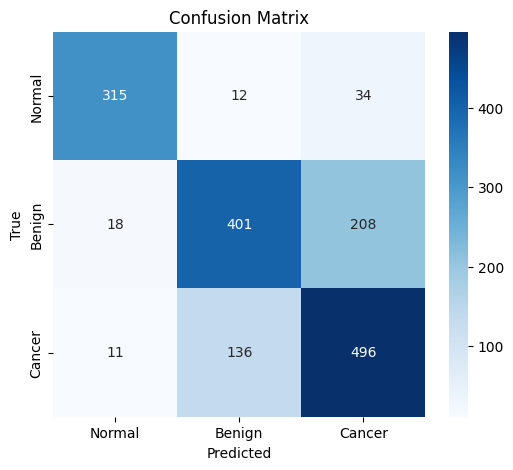

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ["Normal", "Benign", "Cancer"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


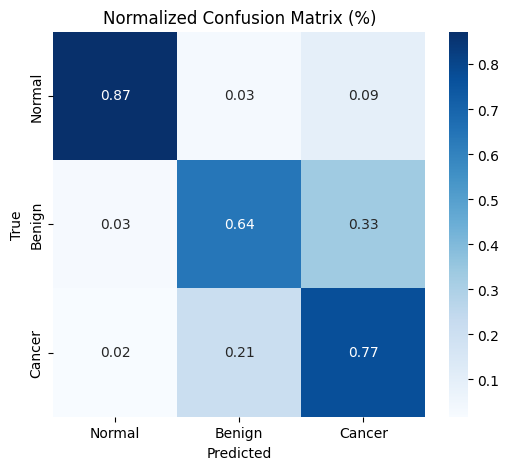

In [ ]:
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (%)")
plt.show()


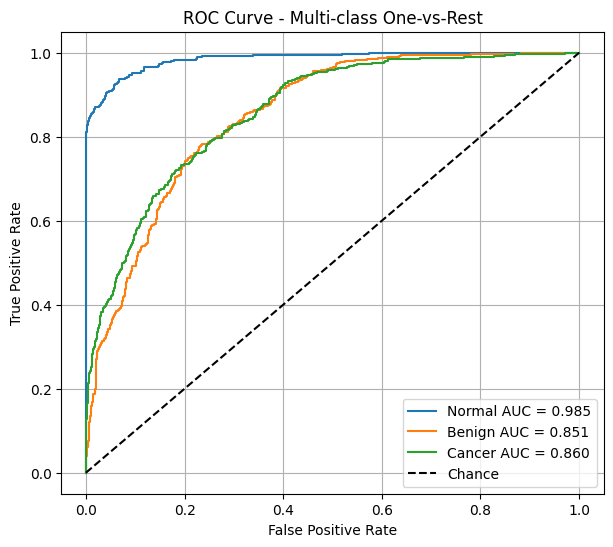

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7,6))

for i, cls in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} AUC = {roc_auc:.3f}")

plt.plot([0,1], [0,1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-class One-vs-Rest")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
from torch.nn import CrossEntropyLoss

loss_fn = FocalLoss(gamma=2, alpha=[1, 1, 2]).to(device)


In [ ]:
for param in model.parameters():
    param.requires_grad = True


In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

CLASS_NAMES = ["Normal", "Benign", "Cancer"]

inference_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.499, 0.499, 0.499],
                         std=[0.240, 0.240, 0.240])
])


In [ ]:
def predict_image(model, image_path, device="cuda"):
    # Charger l'image externe
    img = Image.open(image_path).convert("RGB")

    # Appliquer les mêmes transforms que pendant l'entraînement
    tensor_img = inference_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(tensor_img)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    pred_idx = probs.argmax()
    pred_label = CLASS_NAMES[pred_idx]

    # Affichage de l'image + résultat
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Prediction: {pred_label}\nProbabilities: {probs}")
    plt.show()

    return pred_label, probs


In [ ]:
best_model_path = os.path.join(SAVE_DIR, "best_effnet_b3_3class.pth")

model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.to(DEVICE)

print("Model loaded successfully!")


Model loaded successfully!


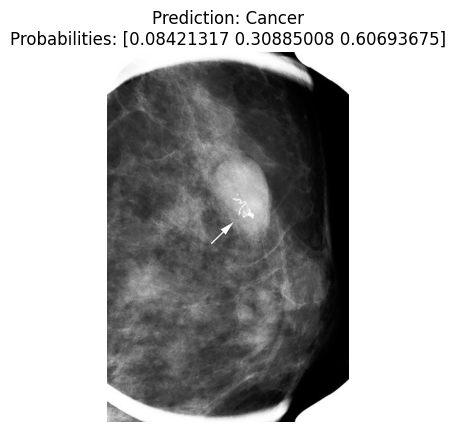

Predicted class: Cancer
Probabilities: [0.08421317 0.30885008 0.60693675]


In [ ]:
label, probabilities = predict_image(model, "test10.jpg", device=DEVICE)

print("Predicted class:", label)
print("Probabilities:", probabilities)
